In [24]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas.plotting import lag_plot

[*********************100%***********************]  1 of 1 completed


Index(['Volume', 'Both_FVG', 'MACD_hist', '1 Period % Change'], dtype='object', name='Price')
                            OLS Regression Results                            
Dep. Variable:      1 Period % Change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.473
Date:                Sat, 21 Jun 2025   Prob (F-statistic):             0.0154
Time:                        12:16:37   Log-Likelihood:                 24609.
No. Observations:                8151   AIC:                        -4.921e+04
Df Residuals:                    8147   BIC:                        -4.918e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

Price,Adj Close,Close,High,Low,Open,Volume,Close + 1,1 Period % Change,High_2prev,Bull_FVG,...,Bear_FVG,Bear_FVG_Val,12_ema,27_ema,MACD,Signal,MACD_hist,Both_FVG,Predictions,Residuals
0,24.380440,43.937500,43.968750,43.750000,43.968750,1003200,44.250000,0.007112,NaN,0,...,0,NaN,43.937500,43.937500,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,24.553852,44.250000,44.250000,43.968750,43.968750,480500,44.343750,0.002119,NaN,0,...,0,NaN,44.106771,44.099537,0.007234,0.004019,0.003215,NaN,NaN,NaN
2,24.605875,44.343750,44.375000,44.125000,44.218750,201300,44.812500,0.010571,43.968750,1,...,0,0.0,44.199264,44.187043,0.012221,0.007380,0.004841,0.003524,0.000221,-0.010350
3,24.865971,44.812500,44.843750,44.375000,44.406250,529400,45.000000,0.004184,44.250000,1,...,0,0.0,44.392839,44.361194,0.031645,0.015600,0.016045,0.002789,0.000266,-0.003918
4,24.970011,45.000000,45.093750,44.468750,44.968750,531500,44.968750,-0.000694,44.375000,1,...,0,0.0,44.557802,44.508556,0.049246,0.025609,0.023637,0.002083,0.000310,0.001005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8149,595.240295,597.000000,601.849976,595.479980,598.500000,89506000,602.679993,0.009514,605.059998,0,...,0,0.0,596.578433,587.608108,8.970325,9.495433,-0.525108,0.000000,0.000528,-0.008986
8150,600.903564,602.679993,604.450012,600.219971,600.400024,79984100,597.530029,-0.008545,603.750000,0,...,0,0.0,597.517134,588.684671,8.832463,9.362839,-0.530376,0.000000,0.000535,0.009080
8151,595.768799,597.530029,601.750000,596.760010,600.210022,82209400,597.440002,-0.000151,601.849976,0,...,0,0.0,597.519118,589.316482,8.202636,9.130799,-0.928163,0.000000,0.000630,0.000780
8152,595.679016,597.440002,601.219971,596.469971,598.440002,76605000,594.280029,-0.005289,604.450012,0,...,0,0.0,597.506947,589.896734,7.610213,8.826681,-1.216469,0.000000,0.000703,0.005992


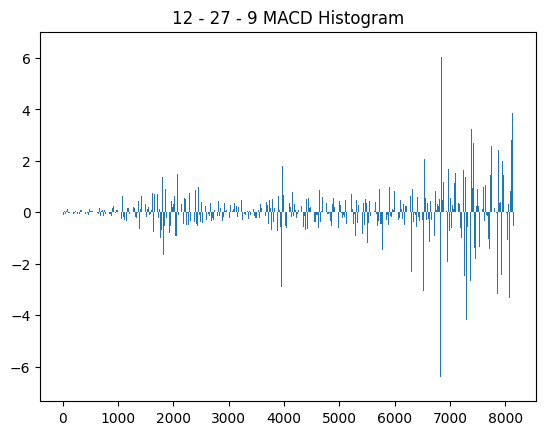

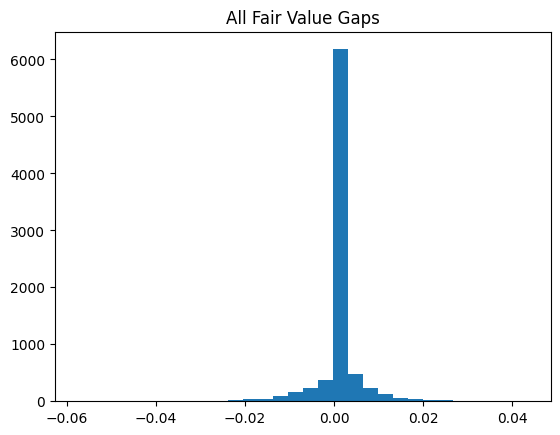

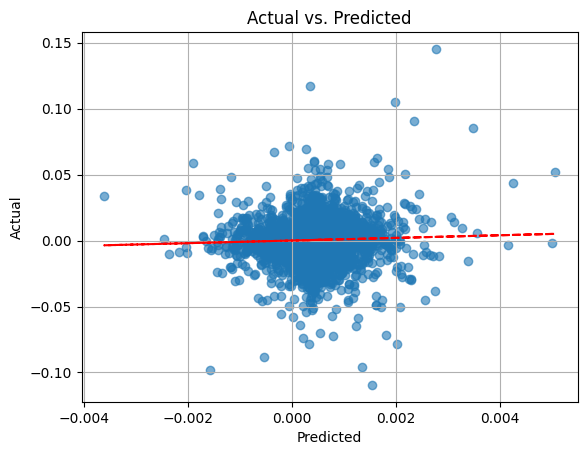

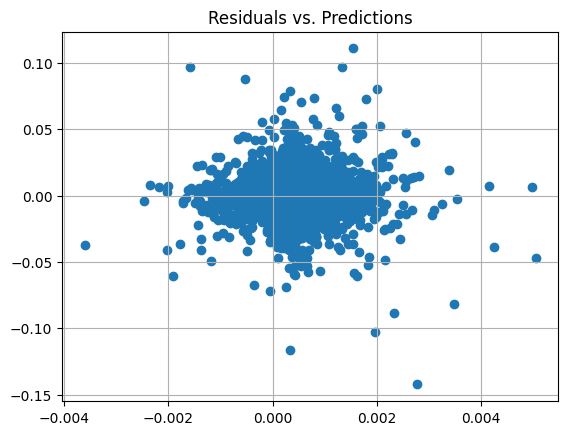

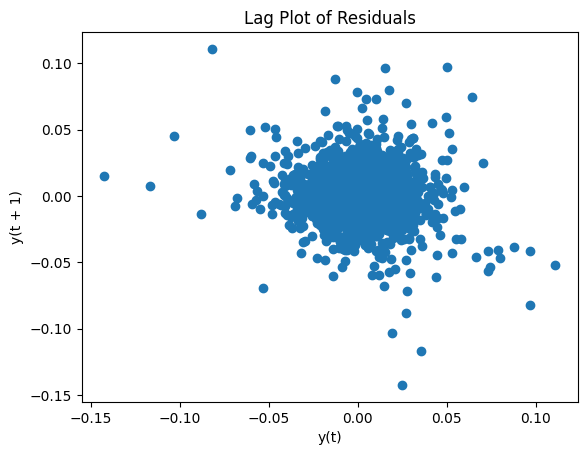

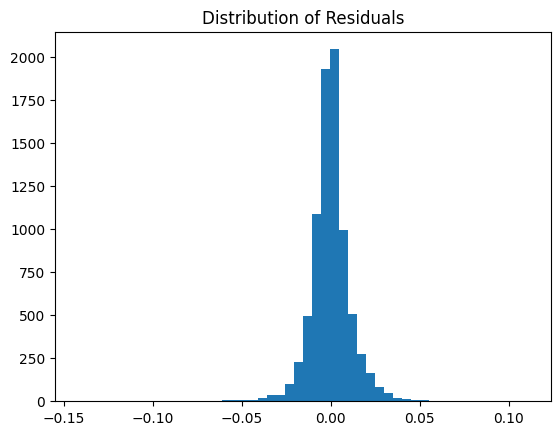

In [ ]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 1
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 10000

STRATEGY = ['Volume', 'Both_FVG', 'MACD_hist']

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df[f'{shift} Period % Change'] = (df[f'Close + {shift}'] - df['Close']) / df['Close']

    return df

def bull_fvg(df):

    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    return df

def bear_fvg(df):

    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    return df

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def prepare_dataframe_for_regression(df):
    # df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
    df['Both_FVG'] = df['Bear_FVG_Val'] + df['Bull_FVG_Val']

    plt.figure()
    plt.hist(df['Both_FVG'], bins=30)
    plt.title('All Fair Value Gaps')

    return df

def generate_regression_output(df, features=STRATEGY, target=f'{SHIFT} Period % Change'):
    subset = df[features + [target]].dropna()

    X = subset[features]
    y = subset[target]

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    intercept = model.params['const']
    coefficients = model.params.drop('const')
    r2 = model.rsquared
    p_values = model.pvalues.drop('const')
    model_p_value = model.f_pvalue  # overall model significance
    n_obs = len(subset)

    y_pred = model.predict(X_with_const)

    # Console summary
    print(model.summary())

    # Plot actual vs predicted
    plt.figure()
    plt.scatter(y_pred, y, alpha=0.6)
    plt.plot(y_pred, y_pred, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Actual vs. Predicted")
    plt.grid(True)

    return df, intercept, coefficients, model_p_value

def validate_regression_output(df, coef, intercept):
    df['Predictions'] = intercept
    for feature in coef.index:
        df['Predictions'] += df[feature] * coef[feature]

    df['Residuals'] = df['Predictions'] - df[f'{SHIFT} Period % Change']

    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Residuals vs. Predictions')
    plt.grid(True)

    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals')

    plt.figure()
    plt.hist(df['Residuals'].dropna(), bins=50)
    plt.title('Distribution of Residuals')

    return df

def main():
    df = get_data()
    df = add_target(df)
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = add_MACD(df)
    df = prepare_dataframe_for_regression(df)
    df, fit_intercept, fit_coefficient, model_pval = generate_regression_output(df)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept)

    print(f"\n[Overall Model Significance] p-value = {model_pval:.6f}")

    return df

df = main()
df